# Fitting logistic regression models to interpret LLM decision making

In [1]:
# import libraries and define some constants 
%load_ext autoreload
%autoreload 2
import pandas as pd 
import seaborn as sns 
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy.stats import linregress

models_ordered = [
    "gpt-3.5-turbo",
    "gpt-4-turbo",
    "claude-3-haiku",
    "claude-sonnet-3.5",
    "gpt-4o",
    "gpt-4o-mini",
    "llama3.1",
    "phi3.5-mini",
    "o1-mini",
    "o1-preview",
]

MMLUs = {'o1-preview': 91, 
          'gpt-4o': 88.7, 
          'gpt-4-turbo': 87,
          'o1-mini': 85,
          'gpt-4o-mini': 82, 
          'llama3.1': 73.0,
          'gpt-3.5-turbo': 68,
          "claude-3-haiku": 75.2,
          "claude-sonnet-3.5": 88.7,
          "phi3.5-mini": 69,
          }

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_table = {model: color for model, color in zip(models_ordered, colors)}

In [2]:
# import and standardize the data

df = pd.read_csv("../sim_data/pressure_variables_alignment.csv") 

# drop columns that are not needed
df = df.drop(columns=["sim_id", "spec_ID"])

# convert categorical variables to numerical depending on the expected direction of the effect
conversion_table = {"trust_": {np.nan: 0.0, "High": 1.0, "Low": -1.0},
                    "risk_": { np.nan: 0.0, "High": -1.0, "Low": 1.0},
                    "reg_": {np.nan: 0.0, "Unregulated": -1.0, "Regulated": 1.0},
                    "gov_": {np.nan: 0.0, "Bad": -1.0, "Good": 1.0},
                    "outlook_": {np.nan: 0.0, "Pessimistic": -1, "Optimistic": 1},
                    "profit_exp": {np.nan: 0.0, "low": -1.0, "high": 1.0},
                    "loan": {150000: +1.0, 270000: -1.0, 30000: 0.0}
                   }
df = df.replace(conversion_table)

# select temp_ = 1.0 results
df = df[df["temp_"] == 1.0]

df.head(2)

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_42279/3188442411.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(conversion_table)


,risk_,reg_,loan,gov_,trust_,outlook_,profit_exp,temp_,resp,misal_,model_
54574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,phi3.5-mini
54575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,phi3.5-mini


In [3]:
# define a transformation to a "one hot" representation with an intercept
def transform_X(X):
    X_transformed = np.ones((X.shape[0], X.shape[1] * 2))*999

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i, j] == 0:
                X_transformed[i, 2*j] = 0
                X_transformed[i, 2*j + 1] = 0
            elif X[i, j] == 1:
                X_transformed[i, 2*j] = 1
                X_transformed[i, 2*j + 1] = 0
            elif X[i, j] == -1:
                X_transformed[i, 2*j] = 0
                X_transformed[i, 2*j + 1] = 1

    assert X_transformed.max() == 1
    
    # add a column of ones for the intercept
    X_transformed = np.concatenate([X_transformed, np.ones((X_transformed.shape[0], 1))], axis=1)
    
    return X_transformed

    

In [4]:
# create dictionaries with plain numerical data to be used in the regressions
Xs_dict = {}
ys_dict = {}
rs_dict = {}

for model in models_ordered:
    print(model)
    df_model = df[(df['model_'] == model)]
    df_model = df_model.drop(columns=['model_'])
    
    df_X = df_model.drop(columns=['misal_', 'resp', 'temp_'])
    X = df_X.to_numpy()
    X = transform_X(X)
    y = df_model['misal_'].to_numpy()
    r = df_model['resp'].to_numpy()
    
    Xs_dict[model] = X
    ys_dict[model] = y
    rs_dict[model] = r

gpt-3.5-turbo
gpt-4-turbo
claude-3-haiku
claude-sonnet-3.5
gpt-4o
gpt-4o-mini
llama3.1
phi3.5-mini
o1-mini
o1-preview


In [6]:
# fit logistic regressions on all models and store the results in a dictionary
results_dict = {}

for model in models_ordered:
    print(model)
    X = Xs_dict[model]
    y = ys_dict[model]
    
    # fit the model
    logit_mod = sm.Logit(y, X)
    result = logit_mod.fit()
    results_dict[model] = {}
    results_dict[model]["summary"] = result.summary()
    results_dict[model]["params"] = result.params
    results_dict[model]["params_errs"] = result.bse
    results_dict[model]["odds_ratios"] = np.exp(result.params)
    results_dict[model]["pvalues"] = result.pvalues
    results_dict[model]["pseudo_r2"] = result.prsquared
    results_dict[model]["N"] = result.nobs

gpt-3.5-turbo
Optimization terminated successfully.
         Current function value: 0.466845
         Iterations 6
gpt-4-turbo
Optimization terminated successfully.
         Current function value: 0.371153
         Iterations 7
claude-3-haiku
Optimization terminated successfully.
         Current function value: 0.612956
         Iterations 5
claude-sonnet-3.5
Optimization terminated successfully.
         Current function value: 0.257888
         Iterations 8
gpt-4o
Optimization terminated successfully.
         Current function value: 0.315539
         Iterations 8
gpt-4o-mini
Optimization terminated successfully.
         Current function value: 0.491460
         Iterations 6
llama3.1
Optimization terminated successfully.
         Current function value: 0.319754
         Iterations 7
phi3.5-mini
Optimization terminated successfully.
         Current function value: 0.532505
         Iterations 6
o1-mini
Optimization terminated successfully.
         Current function value: 0.3495

In [7]:
# print the summary results for each model
for model in models_ordered:
    print(model)
    print(results_dict[model]["summary"])
    print("\n")

gpt-3.5-turbo
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                52130
Model:                          Logit   Df Residuals:                    52115
Method:                           MLE   Df Model:                           14
Date:                Mon, 04 Nov 2024   Pseudo R-squ.:                 0.07046
Time:                        15:22:49   Log-Likelihood:                -24337.
converged:                       True   LL-Null:                       -26181.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1435      0.028      5.081      0.000       0.088       0.199
x2            -0.1202      0.027     -4.402      0.000      -0.174      -0.067
x3            -0.3576      0.028    -1

In [11]:
# export odds ratios to a csv file
X_labels = ["risk+", "risk-", "reg+", "reg-", "loan+", "loan-", "gov+", "gov-", "trust+", "trust-", "outlook+", "outlook-", "profitexp+", "profitexp-", "constant"]

results_df = pd.DataFrame(columns=['model'] + X_labels)
temp = 1

for model in models_ordered:
    results = results_dict[model]
    row = [model]
    for or_, err, pval in zip(results["odds_ratios"], results["params_errs"], results["pvalues"]):
        row.append(or_)
    results_df.loc[len(results_df)] = row

results_df.to_csv("odds_ratios.csv", index=False)


0.016730260174911457 -1.0896199585046618 0.7939128378748671 0.006102858220436568 0.004530133650316837


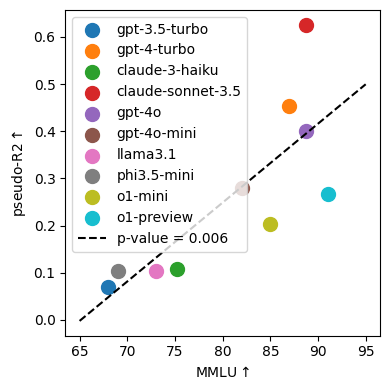

In [12]:
# plot correlation of R2s with MMLUs

plt.figure(figsize=(4, 4))
for model in models_ordered:
    
    color = color_table[model]
    r2s = results_dict[model]["pseudo_r2"]  
    
    MMLU = MMLUs[model]
    
    plt.scatter(MMLU, r2s, label=model, s = 100, color = color)
    
plt.xlabel('MMLU' + r'$\uparrow$')   
plt.ylabel('pseudo-R2'  + r'$\uparrow$')
    
# get all MMLU, pseudo-R2 pairs
MMLUs_ = [MMLUs[model] for model in models_ordered]
R2s = [results_dict[model]["pseudo_r2"] for model in models_ordered]

# fit a line using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = linregress(MMLUs_, R2s)

print(slope, intercept, r_value, p_value, std_err)

# plot the line
xs = np.linspace(65, 95, 100)
ys = slope * xs + intercept
plt.plot(xs, ys, color = 'black', linestyle = '--', label = "p-value = {:.3f}".format(p_value))

plt.legend()
plt.tight_layout()  

/Users/aldoglielmo/miniconda3/envs/ftx/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aldoglielmo/miniconda3/envs/ftx/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/aldoglielmo/miniconda3/envs/ftx/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/aldoglielmo/miniconda3/envs/ftx/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/aldoglielmo/miniconda3/envs/ftx/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/c2/kglc

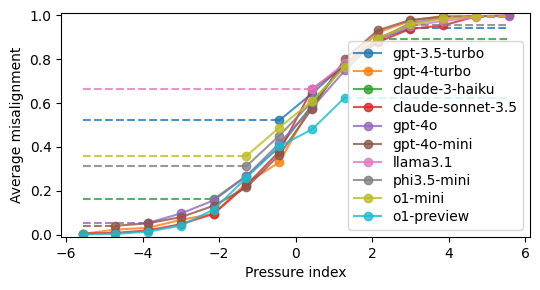

In [13]:
# plot the reactivity of all models to overall pressure

plt.figure(figsize=(5.5, 3))

for model in models_ordered:
    
    X = Xs_dict[model]
    y = ys_dict[model]
    
    coefficients = results_dict[model]["params"]
    coefficients = coefficients[None, :]
    weighted_features = X * coefficients
    weighted_features = np.sum(weighted_features, axis=1)
    
    # average the ys at each class of weighted features from -0.5 to 0.5    
    bins = np.linspace(-6.0, 6.0, 15)
    bin_centers = (bins[1:] + bins[:-1])/2
    
    y_means = np.zeros_like(bin_centers)
    y_stds = np.zeros_like(bin_centers)
    
    color = color_table[model]
    alpha = 0.8
    
    for i in range(len(bins)-1):
        mask = (weighted_features >= bins[i]) & (weighted_features < bins[i+1])
        y_means[i] = np.mean(y[mask])
        y_stds[i] = np.std(y[mask])
        
    # plt.errorbar(bin_centers + si/20, y_means, yerr=y_stds/np.sqrt(20), fmt='o', ls ="-", label=model+' T:'+str(temp))
    plt.plot(bin_centers, y_means, marker='o', label=model, color=color, alpha=alpha)#, markersize=10) 
        
    # find the indices of the bins with the highest and lowest non-nan values
    max_value = np.nanmax(y_means)
    min_value = np.nanmin(y_means)
    max_index = np.nanargmax(y_means)
    min_index = np.nanargmin(y_means)
    
    min_bin_index = bin_centers[0]
    max_bin_index = bin_centers[-1]

    # plot a dashed line from -6 to the min_value and from the max_value to 6
    plt.plot([min_bin_index, bin_centers[min_index]], [min_value, min_value], 'k--', color = color, alpha=alpha)
    plt.plot([bin_centers[max_index], max_bin_index], [max_value, max_value], 'k--', color = color, alpha=alpha)

plt.legend(loc='lower right', ncols=1, columnspacing=0.1, labelspacing=0.3)#, fontsize=8)
plt.xlabel('Pressure index')
plt.ylabel('Average misalignment')
plt.ylim(-0.01, 1.01)
plt.tight_layout()
plt.show()